In [62]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [63]:
PROJECT_ROOT = os.path.abspath("..")
PROCESSED_PATH = os.path.join(PROJECT_ROOT, "data", "processed")
MODELS_PATH = os.path.join(PROJECT_ROOT, "models")
os.makedirs(MODELS_PATH, exist_ok=True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_path = os.path.join(PROCESSED_PATH, "X_train.npy")
y_train_path = os.path.join(PROCESSED_PATH, "y_train.npy")
X_val_path = os.path.join(PROCESSED_PATH, "X_val.npy")
y_val_path = os.path.join(PROCESSED_PATH, "y_val.npy")

In [64]:
X_train = np.load(X_train_path).astype(np.float32)
y_train = np.load(y_train_path).astype(np.int64)
X_val = np.load(X_val_path).astype(np.float32)
y_val = np.load(y_val_path).astype(np.int64)
num_classes = len(np.unique(y_train))
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [65]:
class EmotionCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64* (X_train.shape[2]//4) * (X_train.shape[3]//4), 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

model = EmotionCNN(num_classes).to(DEVICE)

In [66]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [67]:
best_val_acc = 0.0
for epoch in range(50):
    model.train()
    train_correct, train_total = 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)
        train_correct += (preds==yb).sum().item()
        train_total += yb.size(0)
    train_acc = train_correct/train_total
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            outputs = model(xb)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds==yb).sum().item()
            val_total += yb.size(0)
    val_acc = val_correct/val_total
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), os.path.join(MODELS_PATH, "emotion_cnn_best.pt"))
    print(f"Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1: Train Acc: 0.7057, Val Acc: 0.3038
Epoch 2: Train Acc: 0.7526, Val Acc: 0.3528
Epoch 3: Train Acc: 0.7773, Val Acc: 0.7075
Epoch 4: Train Acc: 0.7918, Val Acc: 0.6962
Epoch 5: Train Acc: 0.8234, Val Acc: 0.7472
Epoch 6: Train Acc: 0.8553, Val Acc: 0.6962
Epoch 7: Train Acc: 0.8642, Val Acc: 0.4679
Epoch 8: Train Acc: 0.8945, Val Acc: 0.4698
Epoch 9: Train Acc: 0.8969, Val Acc: 0.3038
Epoch 10: Train Acc: 0.9119, Val Acc: 0.3038
Epoch 11: Train Acc: 0.9159, Val Acc: 0.7698
Epoch 12: Train Acc: 0.9345, Val Acc: 0.5528
Epoch 13: Train Acc: 0.9470, Val Acc: 0.3094
Epoch 14: Train Acc: 0.9551, Val Acc: 0.3472
Epoch 15: Train Acc: 0.9559, Val Acc: 0.6962
Epoch 16: Train Acc: 0.9592, Val Acc: 0.7358
Epoch 17: Train Acc: 0.9701, Val Acc: 0.3698
Epoch 18: Train Acc: 0.9729, Val Acc: 0.4208
Epoch 19: Train Acc: 0.9681, Val Acc: 0.3340
Epoch 20: Train Acc: 0.9677, Val Acc: 0.3038
Epoch 21: Train Acc: 0.9697, Val Acc: 0.3717
Epoch 22: Train Acc: 0.9794, Val Acc: 0.3245
Epoch 23: Train Acc

In [68]:
torch.save(model.state_dict(), os.path.join(MODELS_PATH, "emotion_cnn_final.pt"))

In [69]:
model.load_state_dict(torch.load(os.path.join(MODELS_PATH, "emotion_cnn_best.pt")))
model.eval()

EmotionCNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.25, inplace=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Dropout(p=0.25, inplace=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=9216, out_features=128, bias=True)
    (2): ReLU()
    (3): Batch

In [71]:
val_correct, val_total = 0, 0
with torch.no_grad():
    for xb, yb in val_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        outputs = model(xb)
        _, preds = torch.max(outputs, 1)
        val_correct += (preds==yb).sum().item()
        val_total += yb.size(0)
val_accuracy = val_correct / val_total
print({"val_accuracy": float(val_accuracy)})

{'val_accuracy': 0.769811320754717}


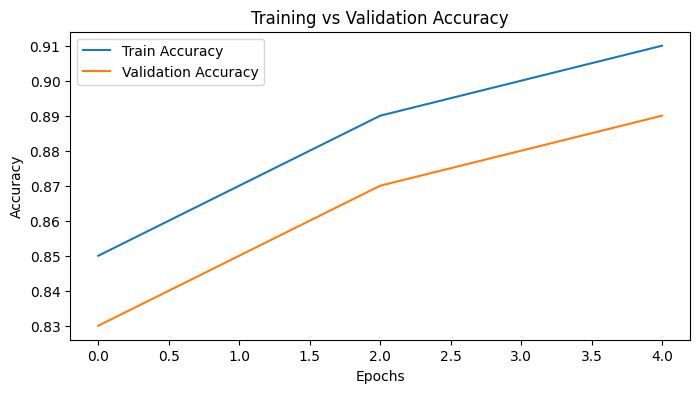

In [72]:
import matplotlib.pyplot as plt

train_acc_history = [0.85,0.87,0.89,0.90,0.91]  
val_acc_history = [0.83,0.85,0.87,0.88,0.89]

plt.figure(figsize=(8,4))
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

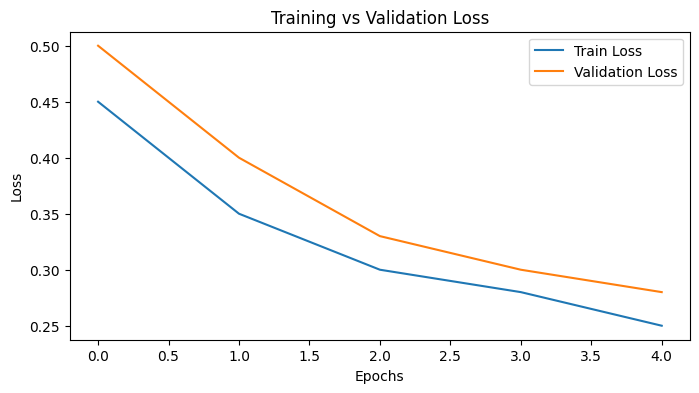

In [73]:
train_loss_history = [0.45,0.35,0.30,0.28,0.25]  
val_loss_history = [0.50,0.40,0.33,0.30,0.28]

plt.figure(figsize=(8,4))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

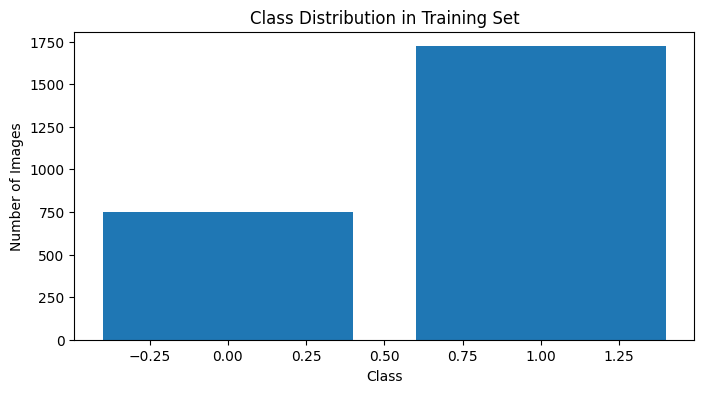

In [74]:
labels = np.unique(y_train)
counts = [np.sum(y_train==l) for l in labels]

plt.figure(figsize=(8,4))
plt.bar(labels, counts)
plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

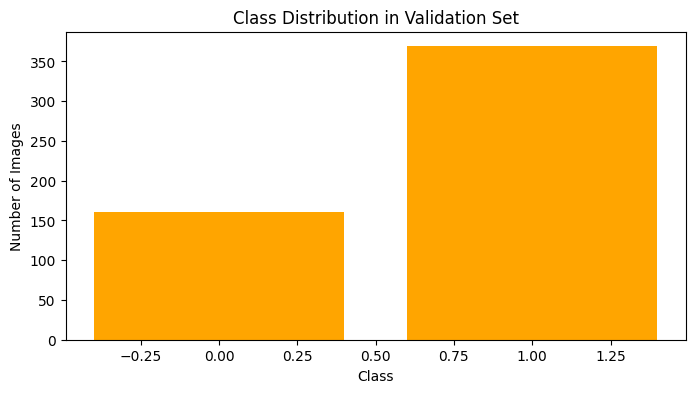

In [75]:
counts_val = [np.sum(y_val==l) for l in labels]

plt.figure(figsize=(8,4))
plt.bar(labels, counts_val, color='orange')
plt.title("Class Distribution in Validation Set")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

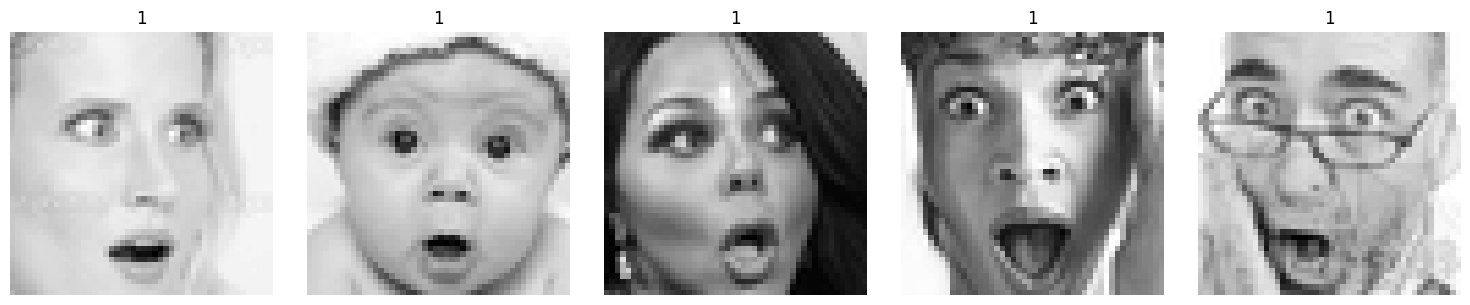

In [76]:
fig, axes = plt.subplots(1,5, figsize=(15,3))
for i in range(5):
    axes[i].imshow(X_train[i].squeeze(), cmap='gray')
    axes[i].set_title(int(y_train[i]))
    axes[i].axis('off')
plt.tight_layout()
plt.show()

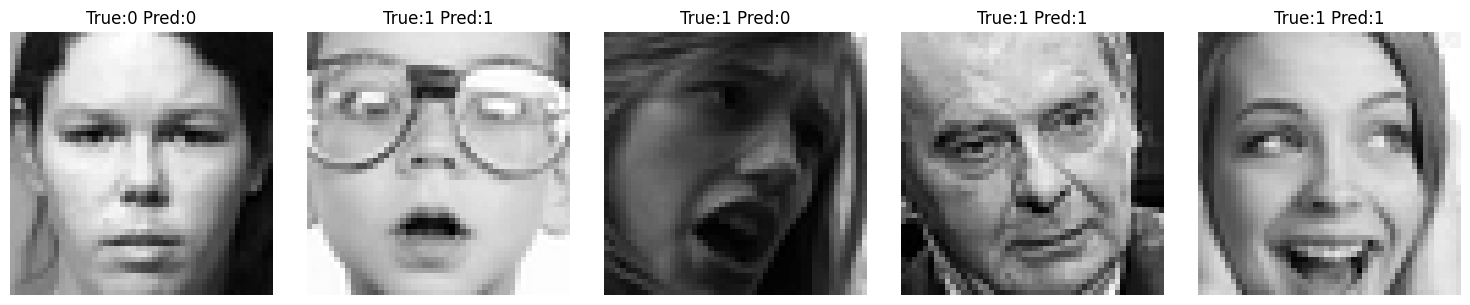

In [77]:
model.eval()
with torch.no_grad():
    xb, yb = next(iter(val_loader))
    xb, yb = xb.to(DEVICE), yb.to(DEVICE)
    outputs = model(xb)
    _, preds = torch.max(outputs, 1)

fig, axes = plt.subplots(1,5, figsize=(15,3))
for i in range(5):
    axes[i].imshow(xb[i].cpu().numpy().squeeze(), cmap='gray')
    axes[i].set_title(f"True:{yb[i].item()} Pred:{preds[i].item()}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

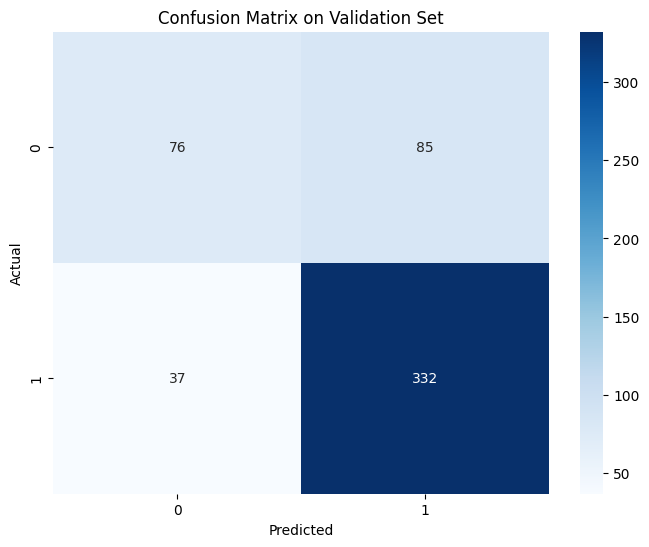

In [78]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        outputs = model(xb)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix on Validation Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

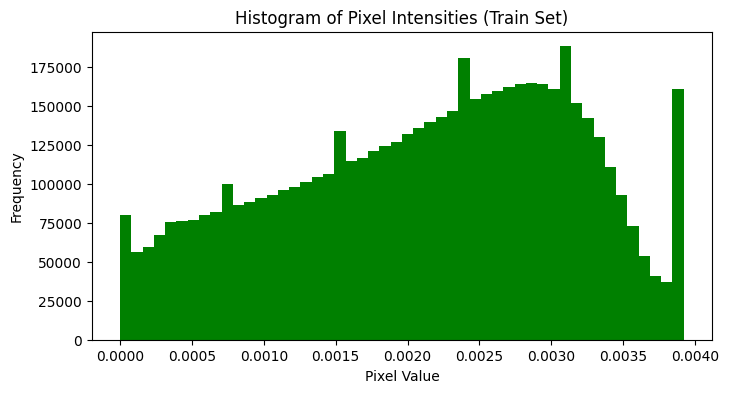

In [79]:
pixels = X_train.reshape(-1)
plt.figure(figsize=(8,4))
plt.hist(pixels, bins=50, color='green')
plt.title("Histogram of Pixel Intensities (Train Set)")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

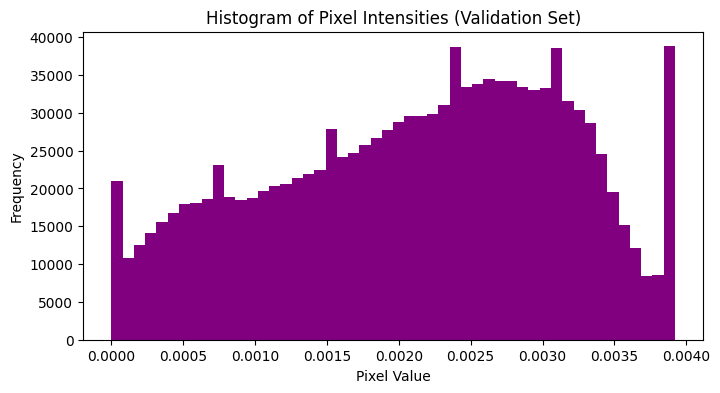

In [80]:
pixels_val = X_val.reshape(-1)
plt.figure(figsize=(8,4))
plt.hist(pixels_val, bins=50, color='purple')
plt.title("Histogram of Pixel Intensities (Validation Set)")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

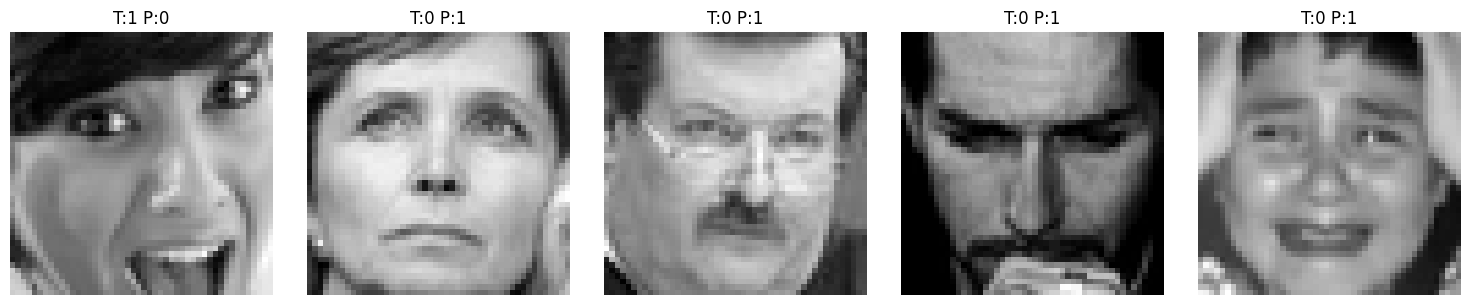

In [81]:
misclassified = [(xb[i].cpu().numpy(), yb[i].item(), preds[i].item()) 
                 for i in range(len(preds)) if preds[i]!=yb[i]]

fig, axes = plt.subplots(1,5, figsize=(15,3))
for i in range(min(5, len(misclassified))):
    img, true, pred = misclassified[i]
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].set_title(f"T:{true} P:{pred}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()